<a href="https://colab.research.google.com/github/Jasonshen5168/DIP-Noise2Noise-/blob/main/Noise2Noise_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
!pip install visualkeras
import visualkeras
import datetime
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = '/content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/Noise2Noise'
if not os.path.exists(save_path):
  os.makedirs(save_path)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train = x_train[:1000]
x_test = x_test[:1000]

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
def add_gaussian_noise(images, mean=0, std=25):
  noise = np.random.normal(mean, std, images.shape)
  noisy_images = images + noise / 255.0
  noisy_images = np.clip(noisy_images, 0, 1)
  return noisy_images

In [ ]:
noisy_x_train_1 = add_gaussian_noise(x_train)
noisy_x_train_2 = add_gaussian_noise(x_train)
noisy_x_test_1 = add_gaussian_noise(x_test)
noisy_x_test_2 = add_gaussian_noise(x_test)

In [ ]:
x_train.shape

(1000, 32, 32, 3)

In [ ]:
def display_and_save_noisy_images(original, noisy1, noisy2, index=0):
  plt.figure(figsize=(15, 5))
  # 原始圖片
  ax = plt.subplot(1, 3, 1)
  plt.imshow(original[index])
  plt.title("Original")
  plt.axis("off")
  plt.savefig(os.path.join(save_path, 'original_image.png'))

  # 添加了第一種噪聲的圖片
  ax = plt.subplot(1, 3, 2)
  plt.imshow(noisy1[index])
  plt.title("Noisy 1")
  plt.axis("off")
  plt.savefig(os.path.join(save_path, 'noisy_image_1.png'))

  # 添加了第二種噪聲的圖片
  ax = plt.subplot(1, 3, 3)
  plt.imshow(noisy2[index])
  plt.title("Noisy 2")
  plt.axis("off")
  plt.savefig(os.path.join(save_path, 'noisy_image_2.png'))

  plt.show()

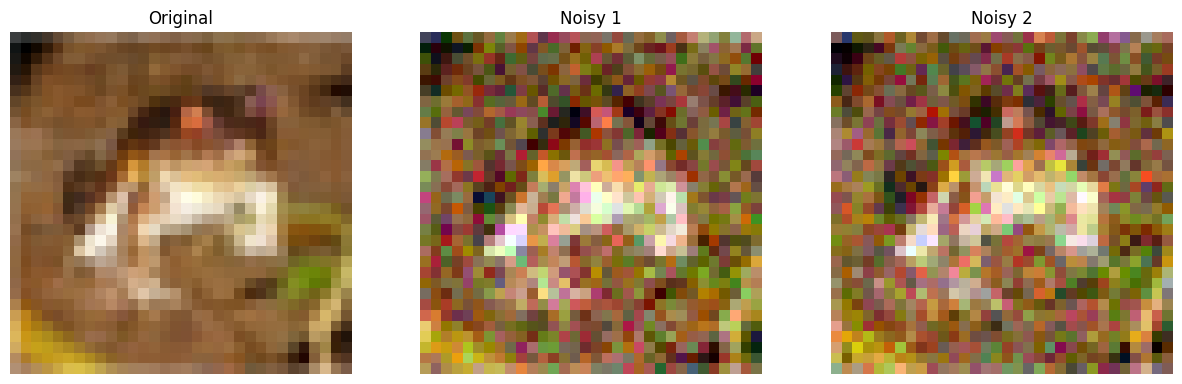

In [ ]:
display_and_save_noisy_images(x_train, noisy_x_train_1, noisy_x_train_2)

In [ ]:
def conv_block(input_tensor, num_filters):
  x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
  x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
  return x


def encoder_block(input_tensor, num_filters):
  x = conv_block(input_tensor, num_filters)
  p = MaxPooling2D((2, 2))(x)
  return x, p


def decoder_block(input_tensor, concat_tensor, num_filters):
  x = UpSampling2D((2, 2))(input_tensor)
  x = Concatenate()([x, concat_tensor])
  x = conv_block(x, num_filters)
  return x


def unet_model(input_shape):
  inputs = Input(shape=input_shape)


  c1, p1 = encoder_block(inputs, 64)
  c2, p2 = encoder_block(p1, 128)
  c3, p3 = encoder_block(p2, 256)
  c4, p4 = encoder_block(p3, 512)

  c5 = conv_block(p4, 1024)

  c6 = decoder_block(c5, c4, 512)
  c7 = decoder_block(c6, c3, 256)
  c8 = decoder_block(c7, c2, 128)
  c9 = decoder_block(c8, c1, 64)

  outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
input_shape = x_train.shape[1:]
model = unet_model(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 32, 32, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 32, 32, 64)           36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 64)           0         ['conv2d_39[0][0]']           
 g2D)                                                                                       

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(noisy_x_train_1, noisy_x_train_2, epochs=60, batch_size=64, validation_data=(noisy_x_test_1, noisy_x_test_2), callbacks=[tensorboard_callback])

Epoch 1/60
16/16 [==============================] - 27s 2s/step - loss: 0.0622 - val_loss: 0.0337
Epoch 2/60
16/16 [==============================] - 24s 1s/step - loss: 0.0467 - val_loss: 0.0321
Epoch 3/60
16/16 [==============================] - 25s 2s/step - loss: 0.0267 - val_loss: 0.0204
Epoch 4/60
16/16 [==============================] - 24s 2s/step - loss: 0.0178 - val_loss: 0.0153
Epoch 5/60
16/16 [==============================] - 25s 2s/step - loss: 0.0144 - val_loss: 0.0135
Epoch 6/60
16/16 [==============================] - 25s 2s/step - loss: 0.0138 - val_loss: 0.0130
Epoch 7/60
16/16 [==============================] - 24s 2s/step - loss: 0.0125 - val_loss: 0.0122
Epoch 8/60
16/16 [==============================] - 24s 2s/step - loss: 0.0120 - val_loss: 0.0118
Epoch 9/60
16/16 [==============================] - 24s 2s/step - loss: 0.0117 - val_loss: 0.0115
Epoch 10/60
16/16 [==============================] - 25s 2s/step - loss: 0.0117 - val_loss: 0.0116
Epoch 11/60
16/16 [

In [ ]:
def plot_learning_curves(history, save_path):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Learning Curves')
  plt.legend()
  plt.grid(True)
  plt.savefig(os.path.join(save_path, 'learning_curves.png'))
  plt.show()

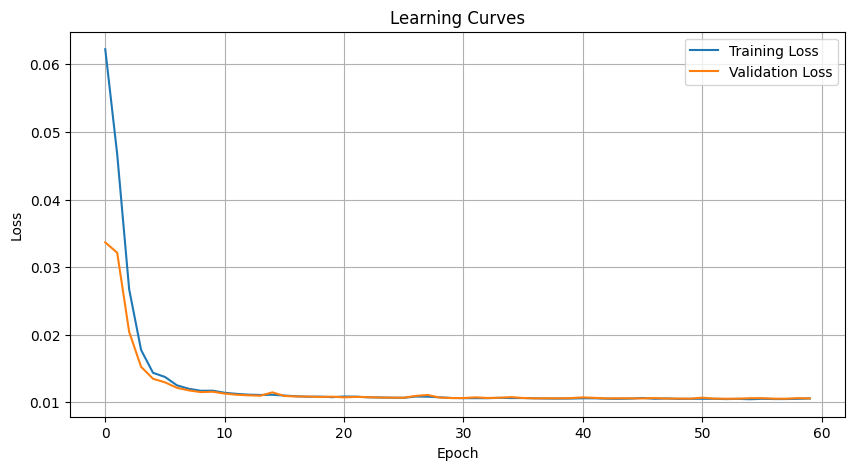

In [ ]:
plot_learning_curves(history, save_path)

In [ ]:
visualkeras.layered_view(model, to_file=os.path.join(save_path, 'unet_model_visualkeras.png')).show()

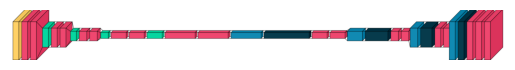

In [ ]:
plt.imshow(plt.imread(os.path.join(save_path, 'unet_model_visualkeras.png')))
plt.axis('off')
plt.show()

In [ ]:
def display_and_save_images(original, noisy, denoised, num_images=5):
  plt.figure(figsize=(15, 5))
  for i in range(num_images):
    # 原始圖片
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(original[i])
    plt.title("Original")
    plt.axis("off")

    # 帶噪聲的圖片
    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # 去噪後的圖片
    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(denoised[i])
    plt.title("Denoised")
    plt.axis("off")

  plt.savefig(os.path.join(save_path, 'comparison_images.png'))
  plt.show()

In [ ]:
denoised_images = model.predict(noisy_x_test_1)

32/32 [==============================] - 3s 79ms/step


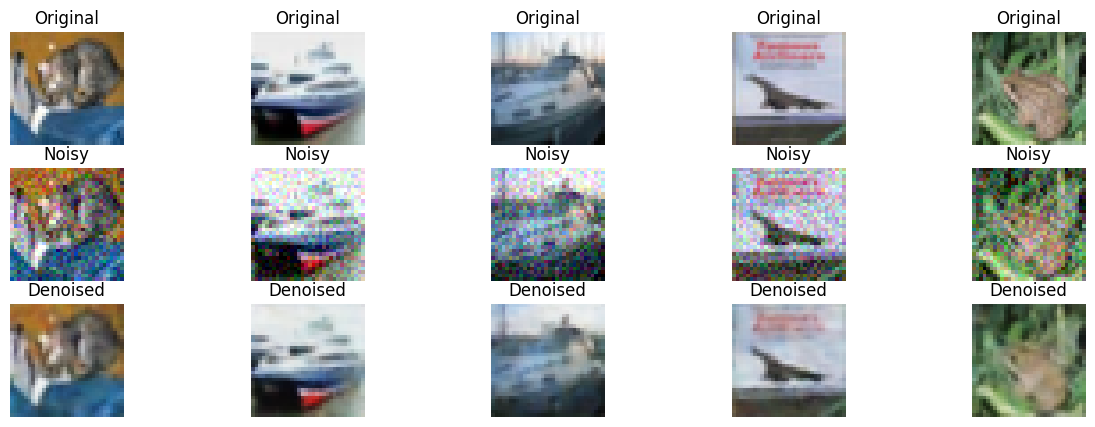

In [ ]:
display_and_save_images(x_test, noisy_x_test_1, denoised_images)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
def calculate_psnr(original, denoised):
    psnr_values = [psnr(original[i], denoised[i]) for i in range(len(original))]
    return np.mean(psnr_values)

psnr_value = calculate_psnr(x_test, denoised_images)
print(f"Average PSNR: {psnr_value:.2f} dB")

Average PSNR: 27.47 dB


32/32 [==============================] - 3s 79ms/step


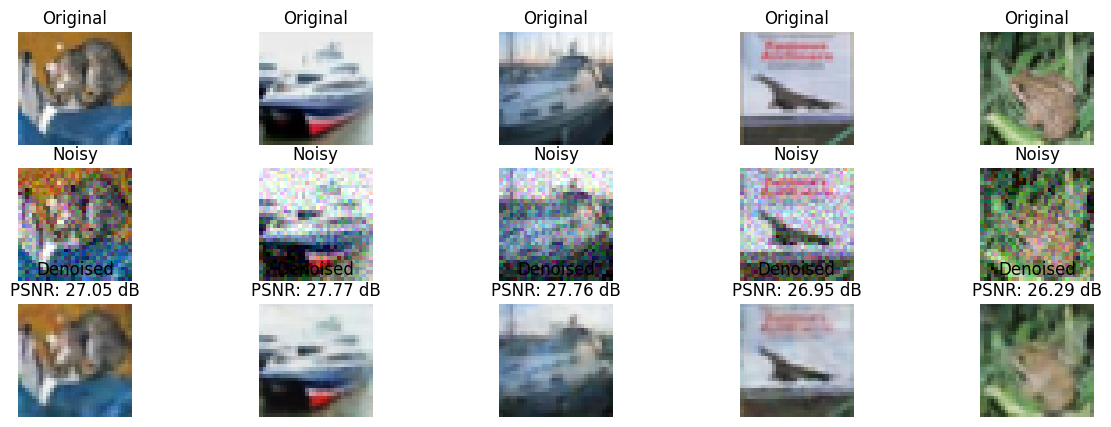

Average PSNR: 27.47 dB


In [ ]:
def display_and_save_images(original, noisy, denoised, num_images=5):
  plt.figure(figsize=(15, 5))
  for i in range(num_images):

    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(original[i])
    plt.title("Original")
    plt.axis("off")


    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(noisy[i])
    plt.title("Noisy")
    plt.axis("off")


    psnr_value = psnr(original[i], denoised[i])
    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(denoised[i])
    plt.title(f"Denoised\nPSNR: {psnr_value:.2f} dB")
    plt.axis("off")

  plt.savefig(os.path.join(save_path, 'comparison_images.png'))
  plt.show()


denoised_images = model.predict(noisy_x_test_1)

display_and_save_images(x_test, noisy_x_test_1, denoised_images)

def calculate_psnr(original, denoised):
    psnr_values = [psnr(original[i], denoised[i]) for i in range(len(original))]
    return np.mean(psnr_values)

psnr_value = calculate_psnr(x_test, denoised_images)
print(f"Average PSNR: {psnr_value:.2f} dB")

32/32 [==============================] - 3s 80ms/step


<ipython-input-59-e1cd5732c184>:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_noisy = psnr(original[i], noisy[i])


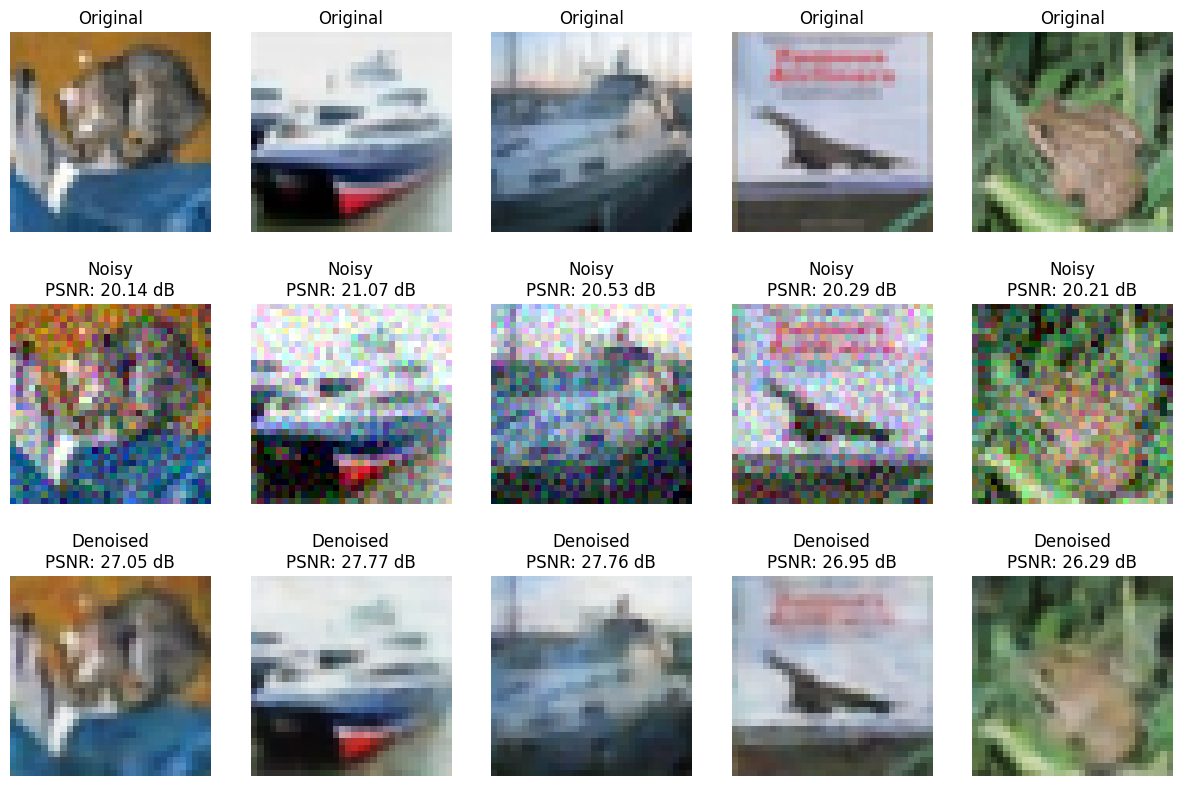

Average PSNR: 27.47 dB


In [ ]:
def display_and_save_images(original, noisy, denoised, num_images=5):
  plt.figure(figsize=(15, 10))
  for i in range(num_images):
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(original[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(noisy[i])
    psnr_noisy = psnr(original[i], noisy[i])
    plt.title(f"Noisy\nPSNR: {psnr_noisy:.2f} dB")
    plt.axis("off")


    psnr_denoised = psnr(original[i], denoised[i])
    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(denoised[i])
    plt.title(f"Denoised\nPSNR: {psnr_denoised:.2f} dB")
    plt.axis("off")

  plt.savefig(os.path.join(save_path, 'comparison_images.png'))
  plt.show()

denoised_images = model.predict(noisy_x_test_1)

display_and_save_images(x_test, noisy_x_test_1, denoised_images)


def calculate_psnr(original, denoised):
    psnr_values = [psnr(original[i], denoised[i]) for i in range(len(original))]
    return np.mean(psnr_values)

psnr_value = calculate_psnr(x_test, denoised_images)
print(f"Average PSNR: {psnr_value:.2f} dB")